In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image,ImageOps, ImageFilter

In [2]:
skin_df = pd.read_csv(r'C:/Users/sammi/minor_project/skin_data/HAM10000_metadata.csv')

In [3]:
image_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(r'C:/Users/sammi/minor_project/skin_data/**/*.jpg', recursive=True)
}

print("Images found:", len(image_path))



Images found: 50075


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


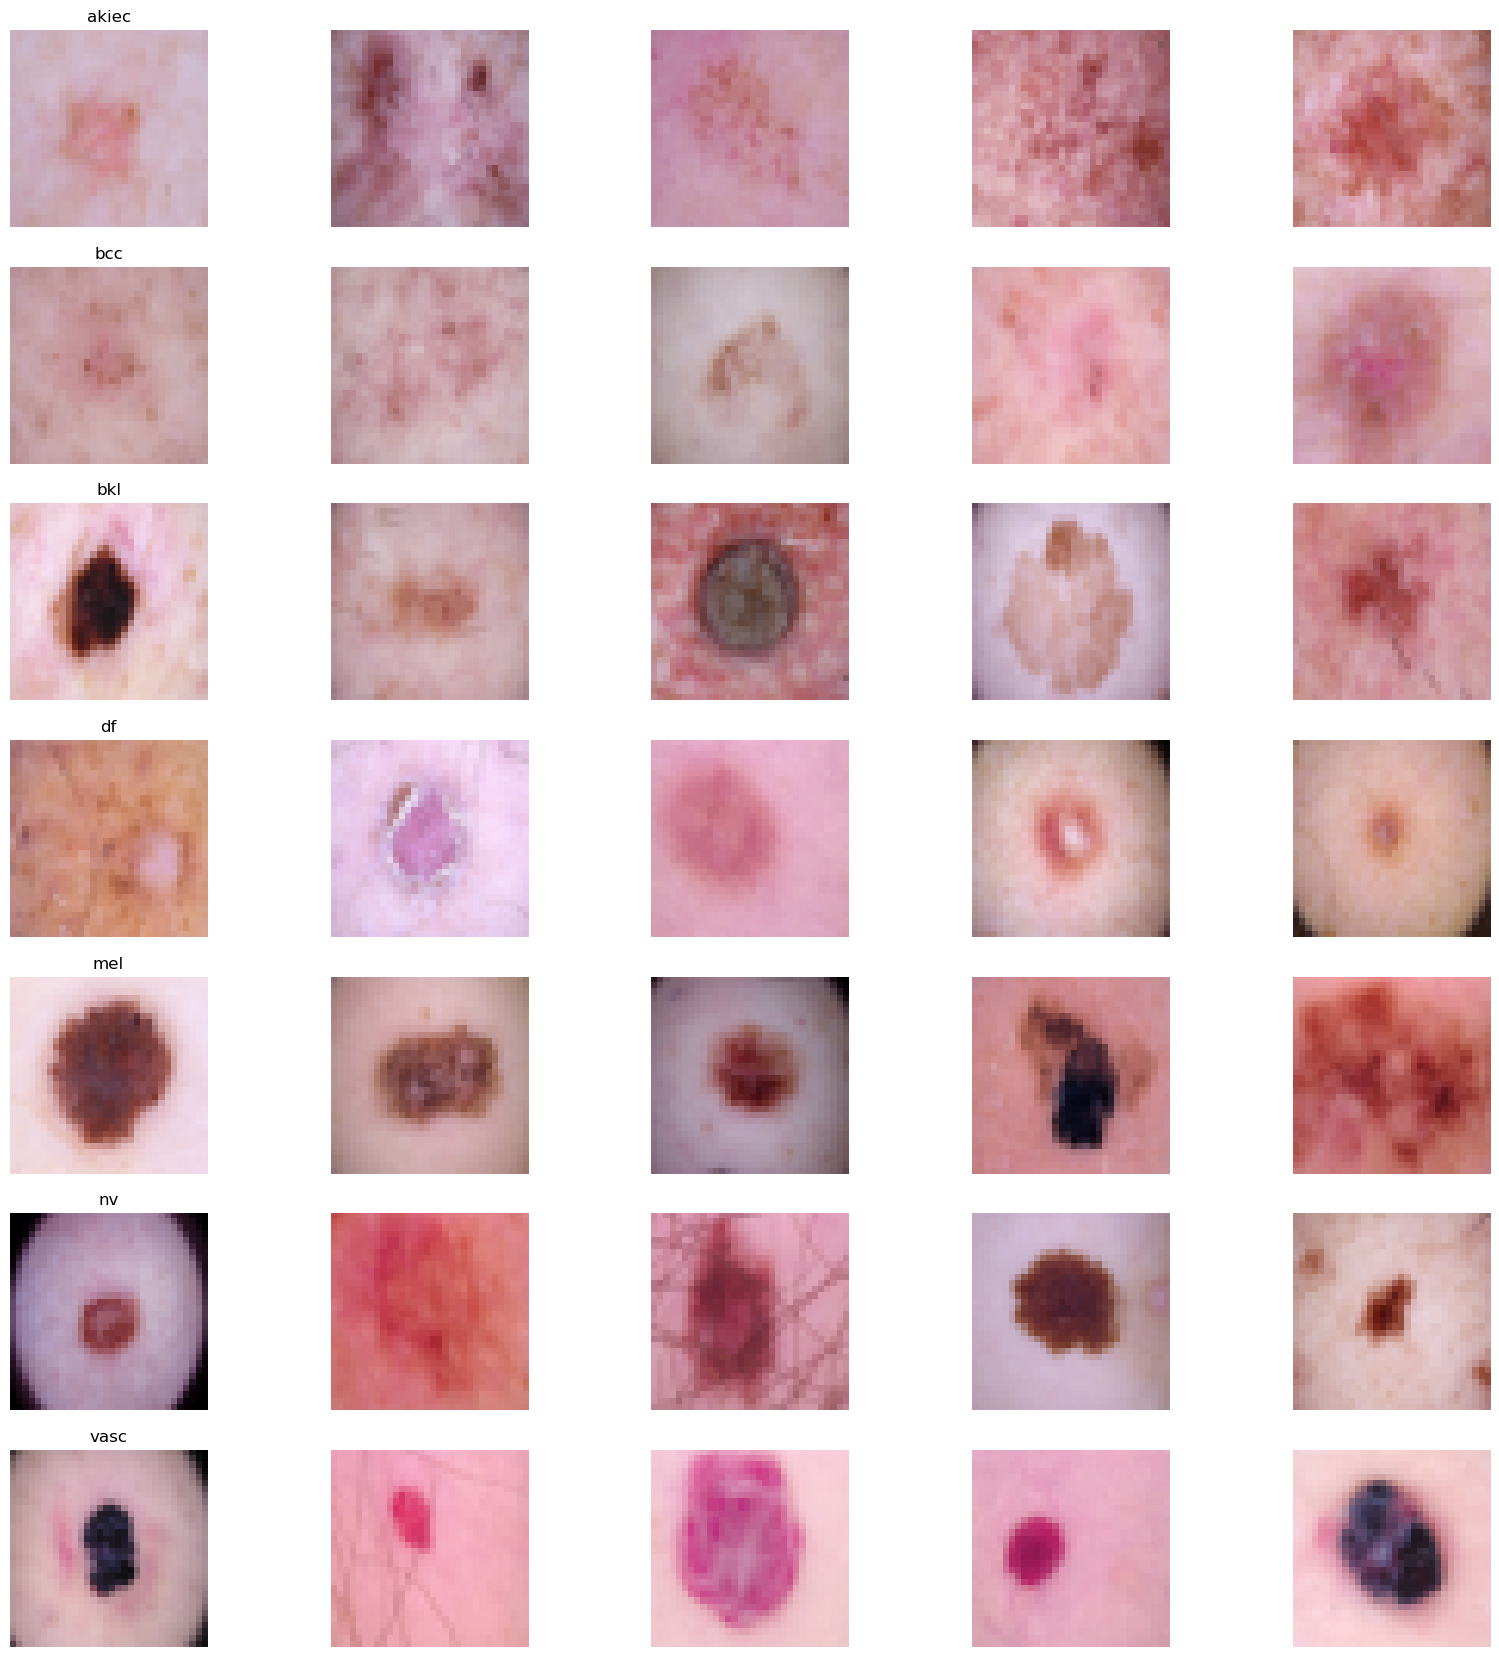

In [4]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)

skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

print(skin_df['dx'].value_counts())

n_samples = 5  # number of samples for plotting

# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(
        m_axs,
        skin_df.sort_values(['dx']).groupby('dx')
    ):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(
            n_axs,
            type_rows.sample(n_samples, random_state=1234).iterrows()
        ):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [5]:
import os
from PIL import Image, ImageOps, ImageEnhance
import numpy as np
from tqdm import tqdm

# params
IMG_SIZE = (32, 32)
OUT_DIR = r'C:/Users/sammi/minor_project/skin_data/augmented'  # folder to store augmented images
n_augs_per_image = 3  # how many augmentations to produce per original image

os.makedirs(OUT_DIR, exist_ok=True)

def random_augment_pil(img: Image.Image, seed=None):
    # img: PIL Image
    # Apply a random chain of augmentations
    if seed is not None:
        np.random.seed(seed)
    # Random flip
    if np.random.rand() < 0.5:
        img = ImageOps.mirror(img)       # horizontal
    if np.random.rand() < 0.2:
        img = ImageOps.flip(img)         # vertical
    # Random rotation (-30,30)
    angle = np.random.uniform(-30, 30)
    img = img.rotate(angle, resample=Image.BILINEAR)
    # Random brightness
    enh = ImageEnhance.Brightness(img)
    img = enh.enhance(np.random.uniform(0.7, 1.3))
    # Random contrast
    enh = ImageEnhance.Contrast(img)
    img = enh.enhance(np.random.uniform(0.8, 1.2))
    # Random crop+resize (zoom)
    w, h = img.size
    zh = np.random.uniform(0.9, 1.0)
    crop_w, crop_h = int(w*zh), int(h*zh)
    left = np.random.randint(0, w - crop_w + 1)
    top  = np.random.randint(0, h - crop_h + 1)
    img = img.crop((left, top, left + crop_w, top + crop_h)).resize(IMG_SIZE, Image.BILINEAR)
    return img

# loop and save
for idx, row in tqdm(skin_df.dropna(subset=['path']).iterrows(), total=skin_df['path'].notnull().sum()):
    src_path = row['path']
    base_id = row['image_id']
    try:
        img = Image.open(src_path).convert('RGB').resize(IMG_SIZE)
    except Exception as e:
        print("skip:", src_path, e)
        continue

    # save original (optional)
    orig_out = os.path.join(OUT_DIR, f"{base_id}_orig.jpg")
    img.save(orig_out, quality=95)

    # produce augmentations
    for i in range(n_augs_per_image):
        aug = random_augment_pil(img)
        out_path = os.path.join(OUT_DIR, f"{base_id}_aug{i+1}.jpg")
        aug.save(out_path, quality=95)


100%|██████████| 10015/10015 [02:20<00:00, 71.52it/s]


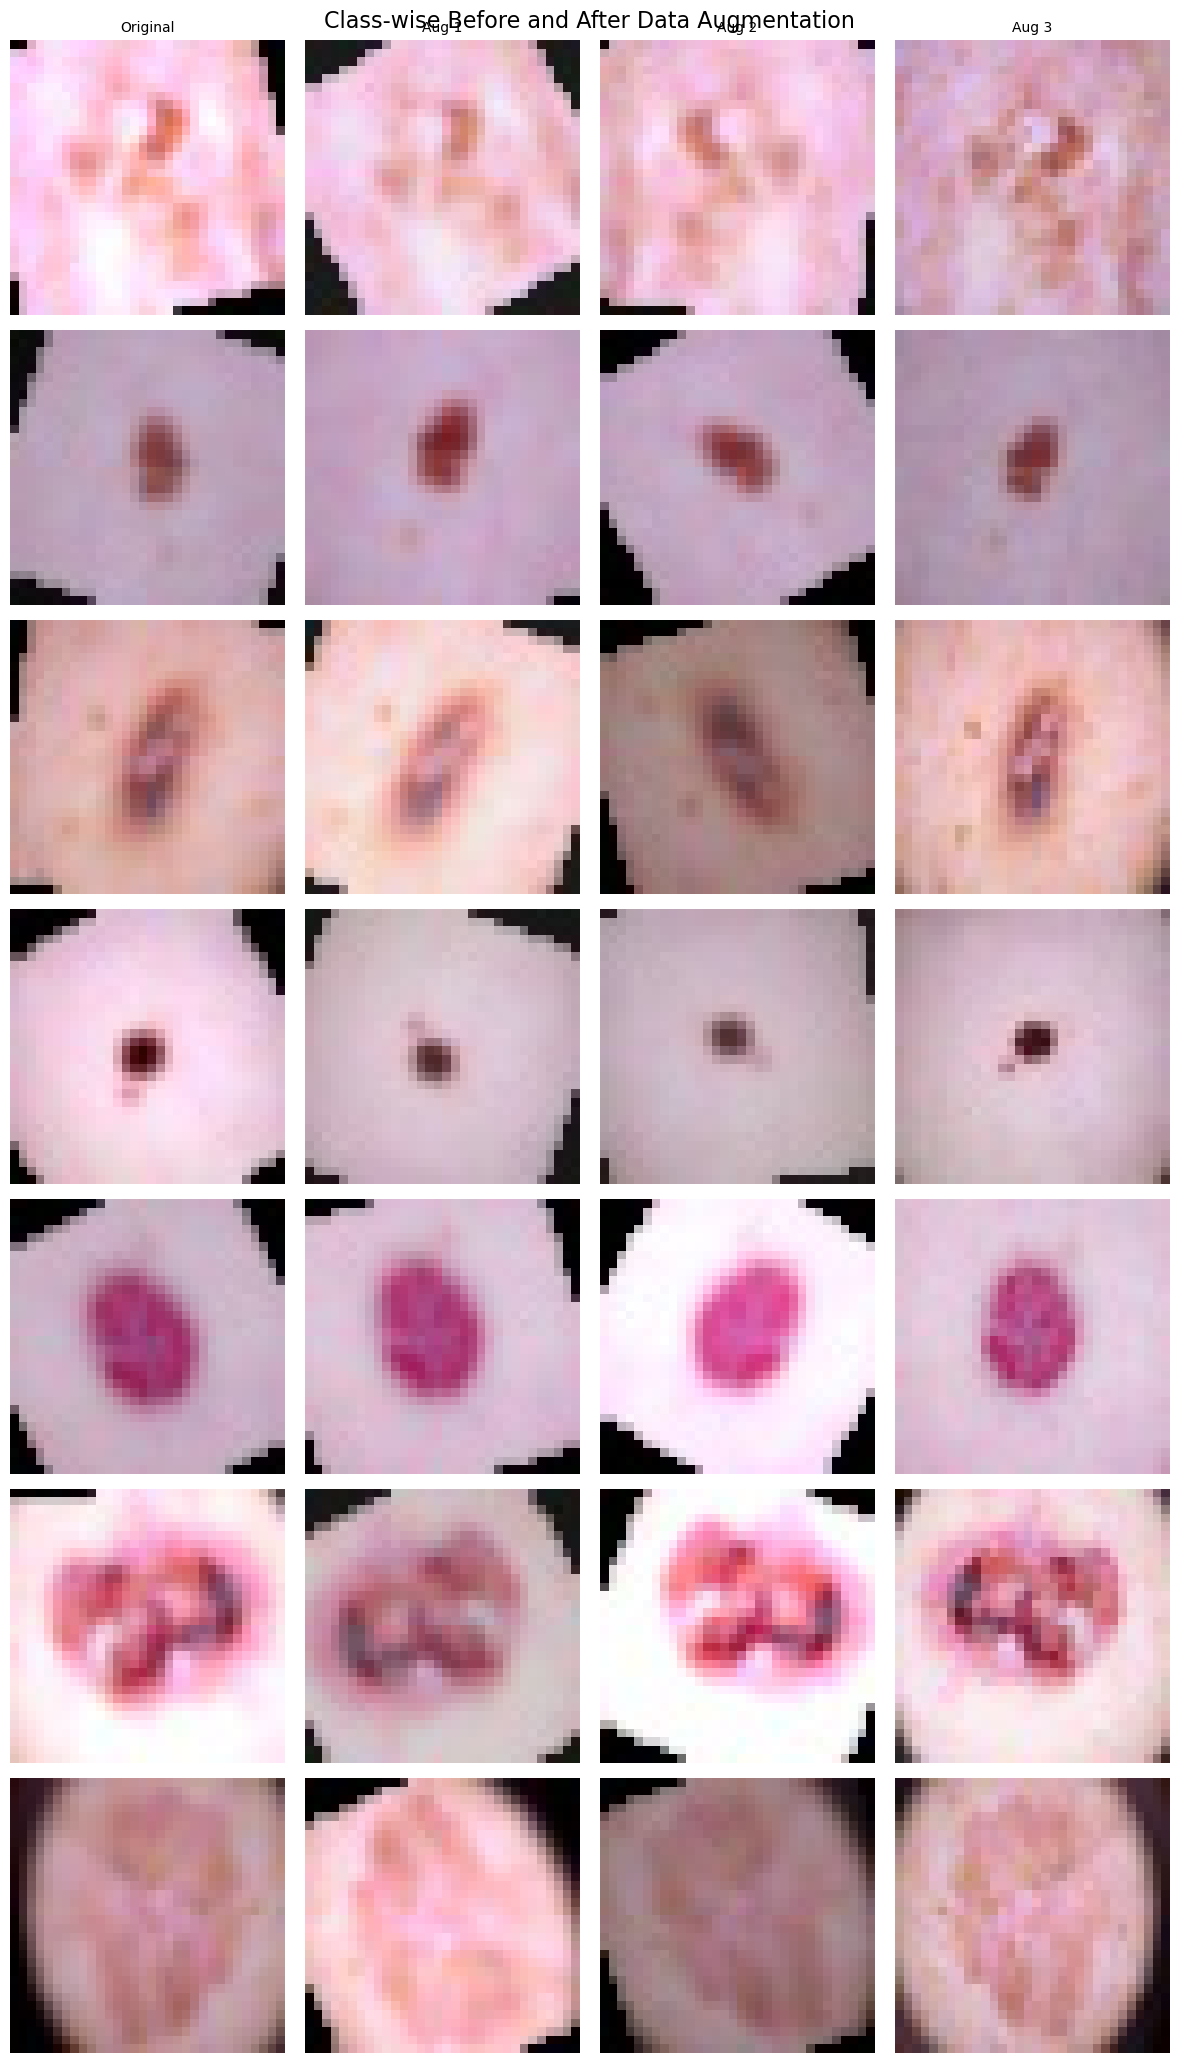

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import os

AUG_DIR = r'C:/Users/sammi/minor_project/skin_data/augmented'

classes = skin_df['dx'].unique()

fig, axes = plt.subplots(len(classes), 4, figsize=(12, 3 * len(classes)))

for row, cls in enumerate(classes):

    # safely pick one image_id for this class
    sample_row = skin_df[skin_df['dx'] == cls].iloc[0]
    img_id = sample_row['image_id']

    # find original + augmented files
    files = sorted([
        f for f in os.listdir(AUG_DIR)
        if f.startswith(img_id)
    ])

    # fallback protection
    if len(files) == 0:
        continue

    # limit to 1 original + 3 augmentations
    files = files[:4]

    for col, fname in enumerate(files):
        img_path = os.path.join(AUG_DIR, fname)
        img = Image.open(img_path)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")

        if row == 0:
            axes[row, col].set_title(
                "Original" if col == 0 else f"Aug {col}",
                fontsize=10
            )

    # add class label on left
    axes[row, 0].set_ylabel(cls, fontsize=12)

plt.suptitle("Class-wise Before and After Data Augmentation", fontsize=16)
plt.tight_layout()
plt.show()


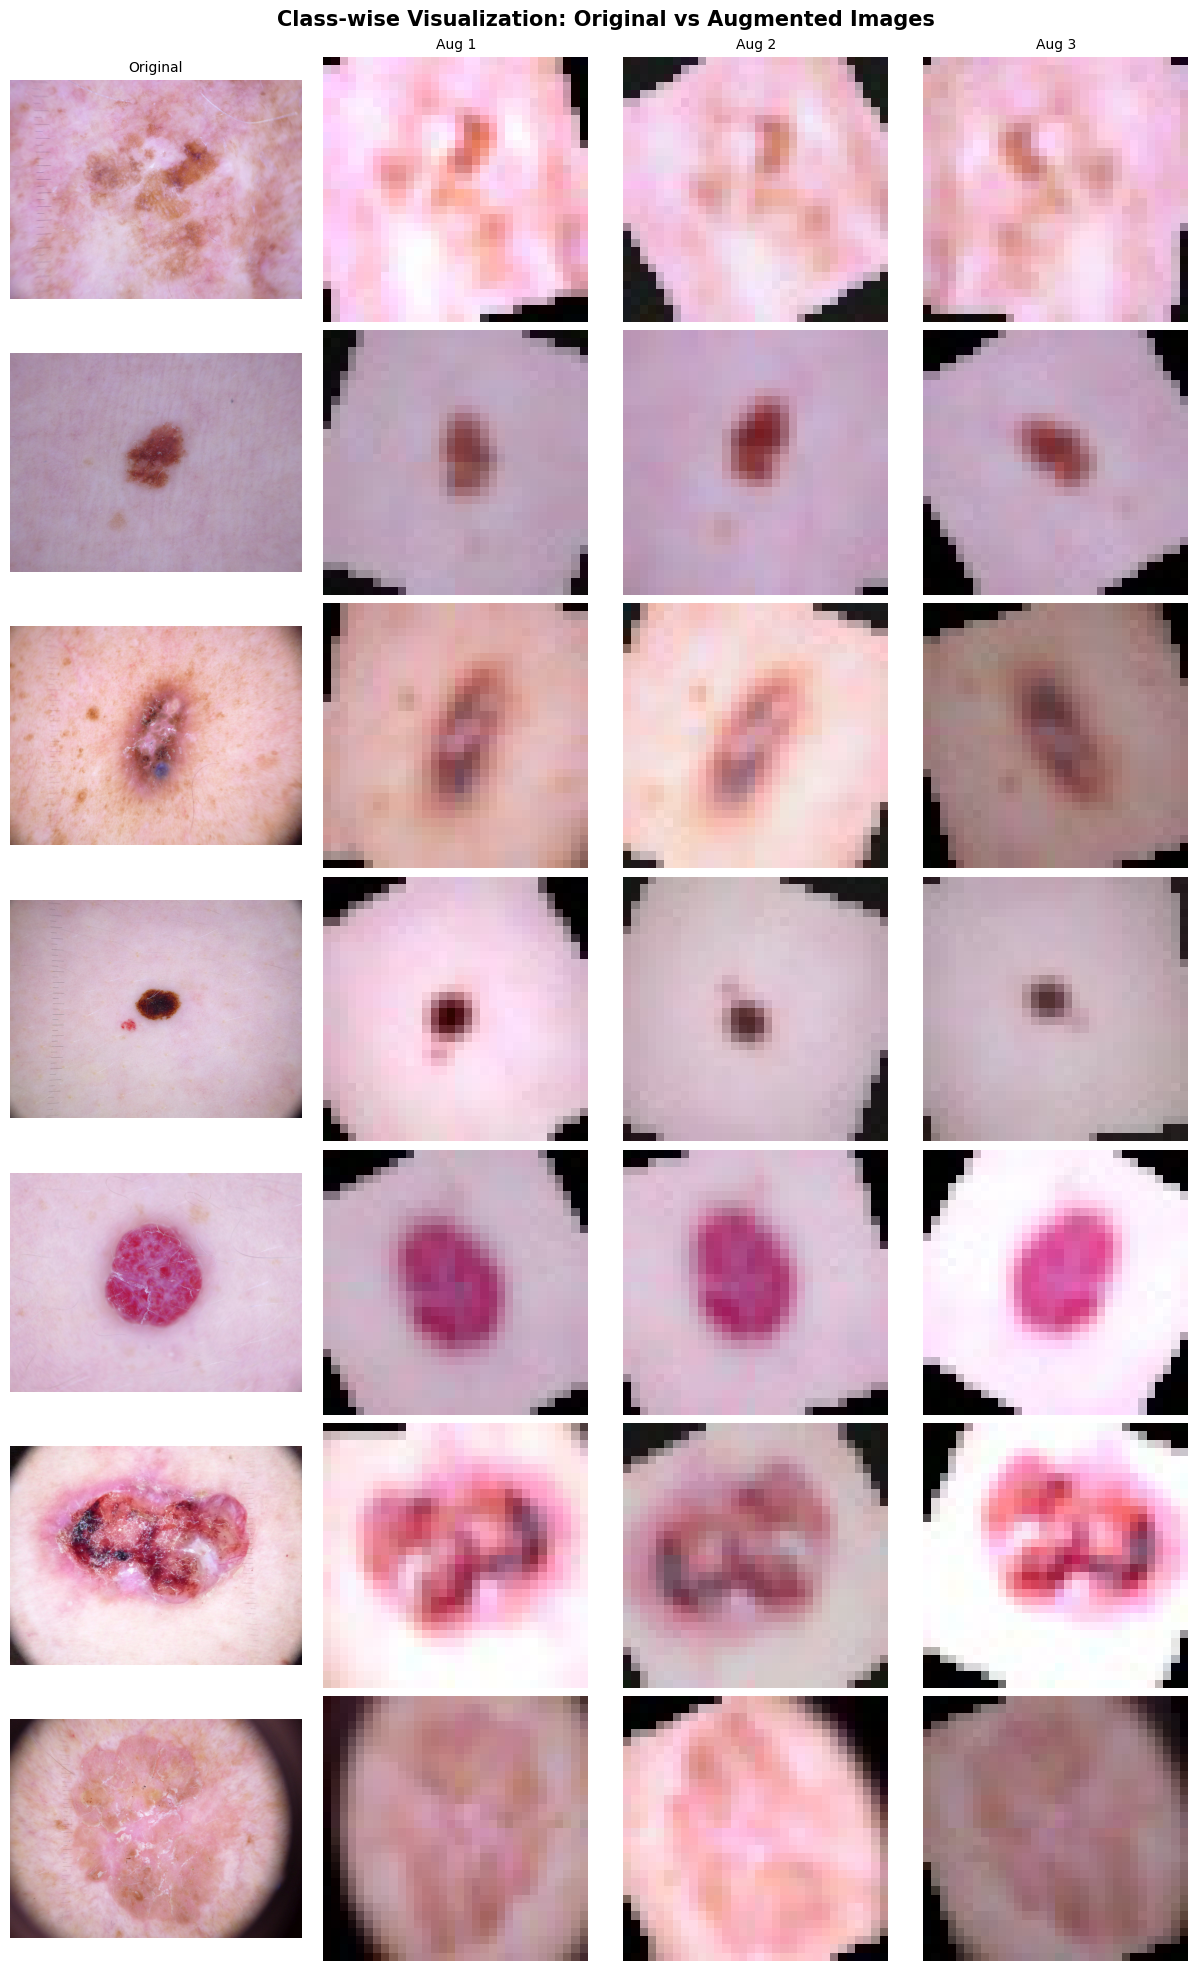

In [7]:
BASE_DIR = r'C:/Users/sammi/minor_project/skin_data'
AUG_DIR  = os.path.join(BASE_DIR, 'augmented')

# original image lookup
orig_paths = {
    os.path.splitext(os.path.basename(p))[0]: p
    for p in glob(os.path.join(BASE_DIR, 'HAM10000_images_part_*', '*.jpg'))
}

classes = skin_df['dx'].unique()

fig, axes = plt.subplots(
    len(classes), 4,
    figsize=(12, 2.8 * len(classes)),
    constrained_layout=True
)

for r, cls in enumerate(classes):

    img_id = skin_df.loc[skin_df['dx'] == cls, 'image_id'].iloc[0]

    # ---- ORIGINAL ----
    axes[r, 0].imshow(Image.open(orig_paths[img_id]))
    axes[r, 0].axis("off")

    if r == 0:
        axes[r, 0].set_title("Original", fontsize=10)

    # ---- AUGMENTED (FIXED) ----
    aug_files = sorted(
        f for f in os.listdir(AUG_DIR)
        if img_id in f
    )

    for c, fname in enumerate(aug_files[:3], start=1):
        axes[r, c].imshow(Image.open(os.path.join(AUG_DIR, fname)))
        axes[r, c].axis("off")

        if r == 0:
            axes[r, c].set_title(f"Aug {c}", fontsize=10)

    axes[r, 0].set_ylabel(cls, rotation=0, labelpad=28, fontsize=11)

plt.suptitle(
    "Class-wise Visualization: Original vs Augmented Images",
    fontsize=15,
    weight="bold"
)
plt.show()


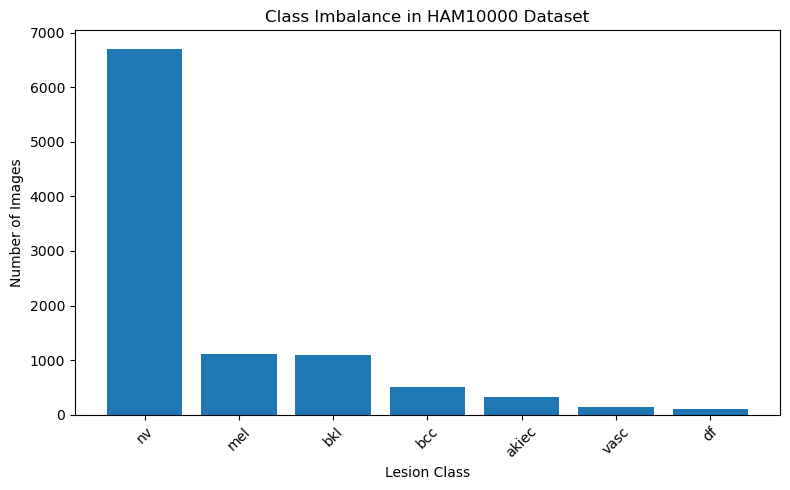

In [8]:
class_counts = skin_df['dx'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Lesion Class")
plt.ylabel("Number of Images")
plt.title("Class Imbalance in HAM10000 Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
binary_map = {
    'nv': 'Healthy',
    'bkl': 'Healthy',
    'df': 'Healthy',
    'mel': 'Unhealthy',
    'bcc': 'Unhealthy',
    'akiec': 'Unhealthy',
    'vasc': 'Unhealthy'
}

skin_df['binary_class'] = skin_df['dx'].map(binary_map)


In [10]:
print(skin_df[['dx', 'binary_class']].drop_duplicates())
print(skin_df['binary_class'].value_counts())


         dx binary_class
0       bkl      Healthy
64       nv      Healthy
1095     df      Healthy
1211    mel    Unhealthy
2320   vasc    Unhealthy
2462    bcc    Unhealthy
9687  akiec    Unhealthy
binary_class
Healthy      7919
Unhealthy    2096
Name: count, dtype: int64


In [11]:
OUT_FILE = r'C:/Users/sammi/minor_project/skin_data/ham10000_binary.csv'
skin_df.to_csv(OUT_FILE, index=False)

print("Saved binary dataset to:", OUT_FILE)


Saved binary dataset to: C:/Users/sammi/minor_project/skin_data/ham10000_binary.csv


In [12]:
# binary encoding
binary_encode = {'Healthy': 0, 'Unhealthy': 1}

skin_df['binary_label'] = skin_df['binary_class'].map(binary_encode)


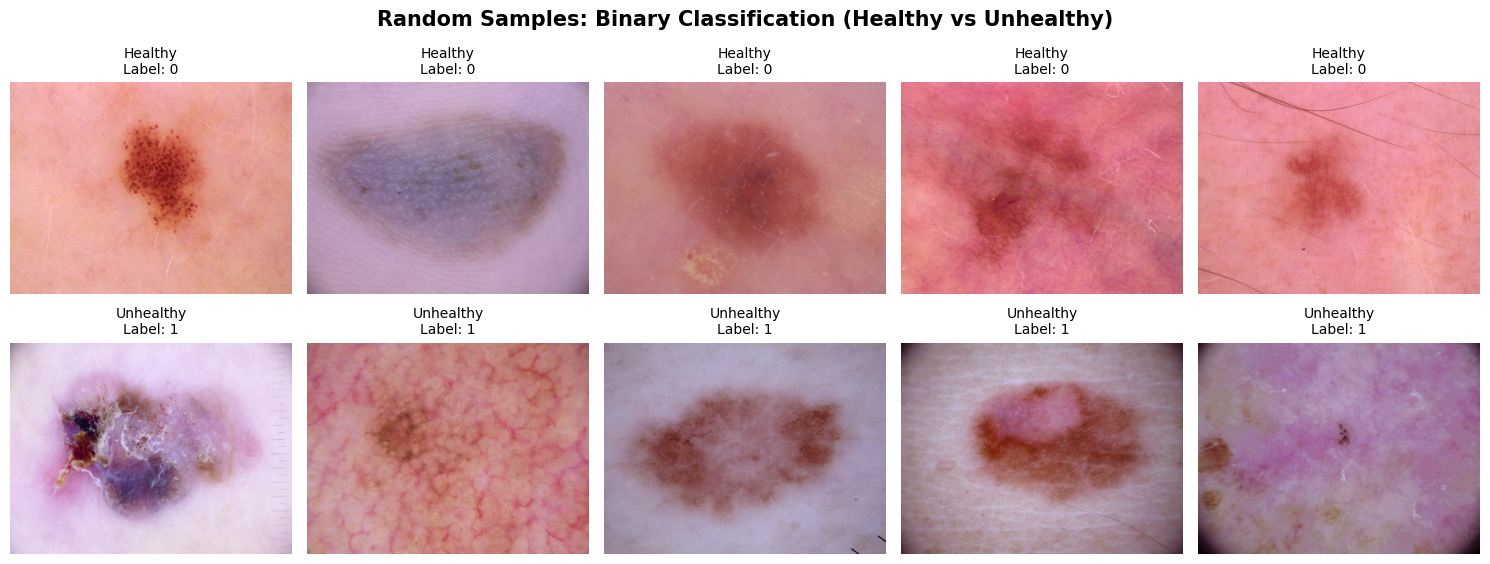

In [13]:
n_samples = 5  # per class

fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 6))

for row, cls in enumerate(['Healthy', 'Unhealthy']):
    sample_df = skin_df[skin_df['binary_class'] == cls].sample(n_samples, random_state=42)

    for col, (_, r) in enumerate(sample_df.iterrows()):
        img = Image.open(r['path'])
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(
            f"{cls}\nLabel: {r['binary_label']}",
            fontsize=10
        )

axes[0, 0].set_ylabel("Healthy (0)", fontsize=12)
axes[1, 0].set_ylabel("Unhealthy (1)", fontsize=12)

plt.suptitle(
    "Random Samples: Binary Classification (Healthy vs Unhealthy)",
    fontsize=15,
    weight="bold"
)
plt.tight_layout()
plt.show()



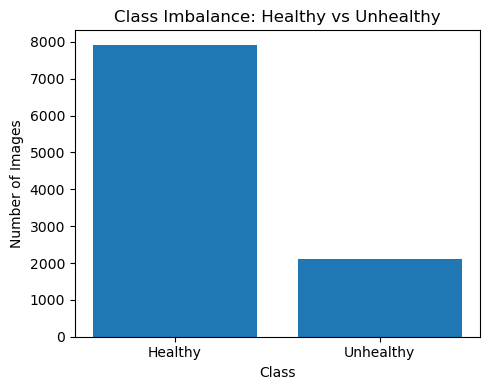

In [14]:
class_counts = skin_df['binary_class'].value_counts()

plt.figure(figsize=(5, 4))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Imbalance: Healthy vs Unhealthy")
plt.tight_layout()
plt.show()


In [15]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [16]:
CSV_PATH = r'C:/Users/sammi/minor_project/skin_data/ham10000_binary.csv'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 5   # increase later if needed

df = pd.read_csv(CSV_PATH)

label_map = {'Healthy': 0, 'Unhealthy': 1}
df['label'] = df['binary_class'].map(label_map)


In [17]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img, label


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df['path'], df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_image).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [19]:
def build_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', input_shape=(*IMG_SIZE, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [20]:
def build_mobilenet():
    base = MobileNetV2(
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [21]:
def build_efficientnet():
    base = EfficientNetB0(
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
        weights='imagenet'
    )
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [22]:
def train_and_evaluate(model, name):
    model.compile(
        optimizer=Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    model.fit(train_ds, epochs=EPOCHS, verbose=1)
    loss, acc = model.evaluate(test_ds, verbose=0)

    print(f"{name} Accuracy: {acc:.4f}")
    return acc


In [23]:
results = []

cnn = build_custom_cnn()
results.append(("Custom CNN", train_and_evaluate(cnn, "Custom CNN")))

mobilenet = build_mobilenet()
results.append(("MobileNetV2", train_and_evaluate(mobilenet, "MobileNetV2")))

efficientnet = build_efficientnet()
results.append(("EfficientNetB0", train_and_evaluate(efficientnet, "EfficientNetB0")))


Epoch 1/5


C:\Users\sammi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 36s 131ms/step - accuracy: 0.7887 - loss: 0.4690
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.7911 - loss: 0.4290
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - accuracy: 0.7976 - loss: 0.4118
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 121ms/step - accuracy: 0.8122 - loss: 0.3946
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - accuracy: 0.8155 - loss: 0.3867
Custom CNN Accuracy: 0.8088
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - accuracy: 0.7792 - loss: 0.5014
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - accuracy: 0.8054 - loss: 0.4244
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.8143 - loss: 0.4009
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - accuracy: 0.8189 - loss: 0.3887
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.8236 - loss: 0.3810
MobileNetV2 Accuracy: 0.8218
Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 156ms/step - accuracy: 0.7589 

In [24]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
results_df = results_df.sort_values(by="Accuracy", ascending=False)

print(results_df)


            Model  Accuracy
1     MobileNetV2  0.821767
0      Custom CNN  0.808787
2  EfficientNetB0  0.790814


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step


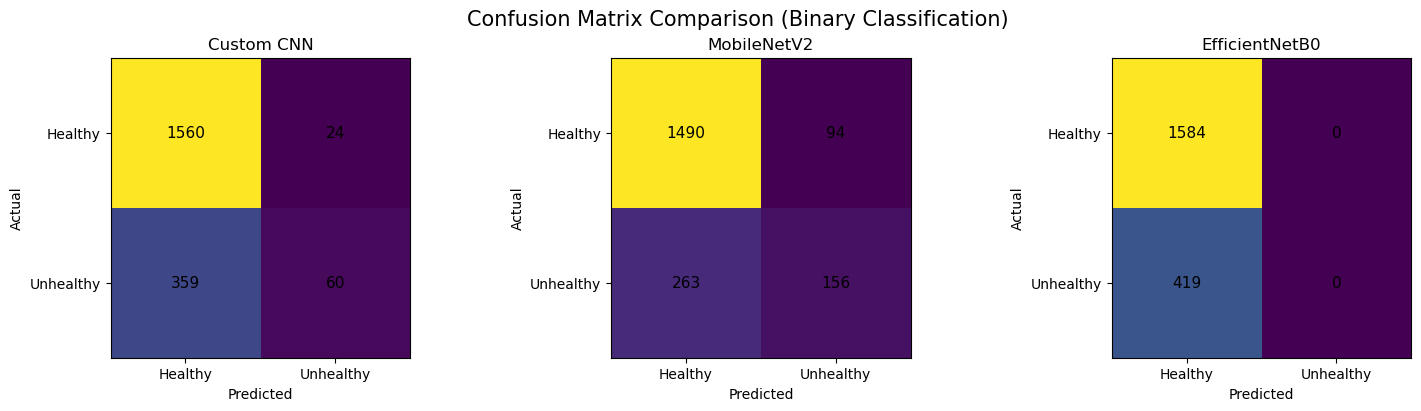

In [25]:
y_true = np.concatenate([y for _, y in test_ds], axis=0)
def get_predictions(model, dataset):
    y_prob = model.predict(dataset)
    y_pred = (y_prob > 0.5).astype(int).ravel()
    return y_pred
y_pred_cnn = get_predictions(cnn, test_ds)
y_pred_mobilenet = get_predictions(mobilenet, test_ds)
y_pred_efficientnet = get_predictions(efficientnet, test_ds)
from sklearn.metrics import confusion_matrix

models_preds = {
    "Custom CNN": y_pred_cnn,
    "MobileNetV2": y_pred_mobilenet,
    "EfficientNetB0": y_pred_efficientnet
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

for ax, (name, y_pred) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_true, y_pred)

    ax.imshow(cm)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Healthy", "Unhealthy"])
    ax.set_yticklabels(["Healthy", "Unhealthy"])

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center", fontsize=11)

plt.suptitle("Confusion Matrix Comparison (Binary Classification)", fontsize=15)
plt.show()


In [26]:
from sklearn.metrics import classification_report

print("=== Custom CNN ===")
print(classification_report(
    y_true, y_pred_cnn,
    target_names=["Healthy", "Unhealthy"]
))

print("=== MobileNetV2 ===")
print(classification_report(
    y_true, y_pred_mobilenet,
    target_names=["Healthy", "Unhealthy"]
))

print("=== EfficientNetB0 ===")
print(classification_report(
    y_true, y_pred_efficientnet,
    target_names=["Healthy", "Unhealthy"]
))


=== Custom CNN ===
              precision    recall  f1-score   support

     Healthy       0.81      0.98      0.89      1584
   Unhealthy       0.71      0.14      0.24       419

    accuracy                           0.81      2003
   macro avg       0.76      0.56      0.56      2003
weighted avg       0.79      0.81      0.75      2003

=== MobileNetV2 ===
              precision    recall  f1-score   support

     Healthy       0.85      0.94      0.89      1584
   Unhealthy       0.62      0.37      0.47       419

    accuracy                           0.82      2003
   macro avg       0.74      0.66      0.68      2003
weighted avg       0.80      0.82      0.80      2003

=== EfficientNetB0 ===
              precision    recall  f1-score   support

     Healthy       0.79      1.00      0.88      1584
   Unhealthy       0.00      0.00      0.00       419

    accuracy                           0.79      2003
   macro avg       0.40      0.50      0.44      2003
weighted avg

C:\Users\sammi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sammi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sammi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = []

models_data = {
    "Custom CNN": y_pred_cnn,
    "MobileNetV2": y_pred_mobilenet,
    "EfficientNetB0": y_pred_efficientnet
}

for model_name, y_pred in models_data.items():
    metrics.append([
        model_name,
        accuracy_score(y_true, y_pred),
        precision_score(y_true, y_pred),
        recall_score(y_true, y_pred),
        f1_score(y_true, y_pred)
    ])

metrics_df = pd.DataFrame(
    metrics,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"]
)

metrics_df


C:\Users\sammi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,F1-score
0,Custom CNN,0.808787,0.714286,0.143198,0.238569
1,MobileNetV2,0.821767,0.624000,0.372315,0.466368
2,EfficientNetB0,0.790814,0.000000,0.000000,0.000000


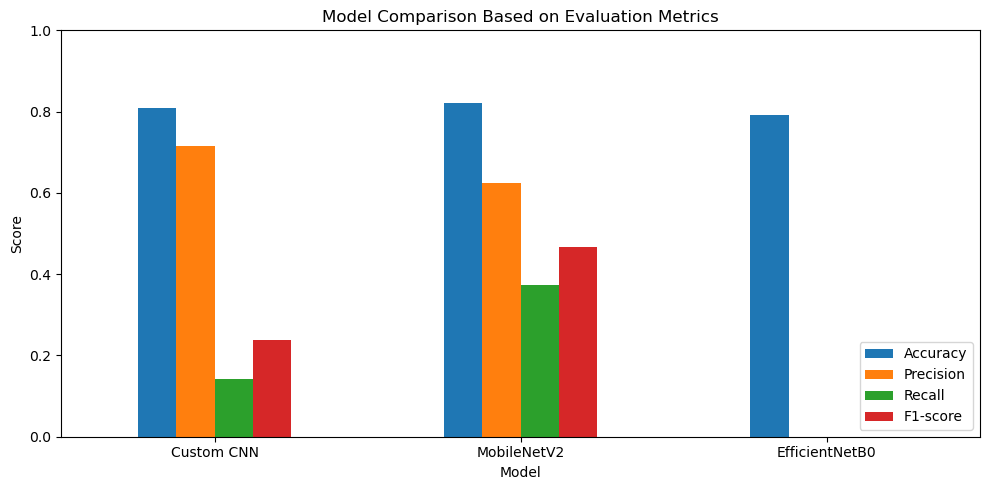

In [28]:
metrics_df.set_index("Model").plot(
    kind="bar",
    figsize=(10, 5)
)

plt.ylabel("Score")
plt.title("Model Comparison Based on Evaluation Metrics")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [29]:
# based on the above selection process and model accuracy sccore will can conclude a model that is 
# MobileNetV2 which show better scores then other model 

In [30]:
IMG_SIZE = (128, 128)

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(*IMG_SIZE, 3),
    weights="imagenet"
)

base_model.trainable = False  # keep frozen (correct decision)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [32]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "mobilenetv2_skin_cancer.h5",
        monitor="val_loss",
        save_best_only=True
    )
]


In [33]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7499 - loss: 0.5373 

251/251 ━━━━━━━━━━━━━━━━━━━━ 55s 197ms/step - accuracy: 0.7946 - loss: 0.4482 - val_accuracy: 0.8278 - val_loss: 0.3686
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8245 - loss: 0.3873 

251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 187ms/step - accuracy: 0.8298 - loss: 0.3736 - val_accuracy: 0.8337 - val_loss: 0.3552
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - accuracy: 0.8412 - loss: 0.3500 - val_accuracy: 0.8303 - val_loss: 0.3559
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8466 - loss: 0.3468 

251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.8507 - loss: 0.3335 - val_accuracy: 0.8357 - val_loss: 0.3494
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8473 - loss: 0.3302 

251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 187ms/step - accuracy: 0.8537 - loss: 0.3222 - val_accuracy: 0.8377 - val_loss: 0.3430
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8633 - loss: 0.3129 

251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.8632 - loss: 0.3101 - val_accuracy: 0.8412 - val_loss: 0.3408
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8578 - loss: 0.3048 

251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.8645 - loss: 0.2997 - val_accuracy: 0.8447 - val_loss: 0.3374
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8663 - loss: 0.2996 

251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 187ms/step - accuracy: 0.8739 - loss: 0.2909 - val_accuracy: 0.8467 - val_loss: 0.3328
Epoch 9/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8716 - loss: 0.2881 

251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 186ms/step - accuracy: 0.8763 - loss: 0.2815 - val_accuracy: 0.8477 - val_loss: 0.3311
Epoch 10/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.8822 - loss: 0.2760 - val_accuracy: 0.8442 - val_loss: 0.3396
Epoch 11/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8857 - loss: 0.2689 

251/251 ━━━━━━━━━━━━━━━━━━━━ 47s 185ms/step - accuracy: 0.8844 - loss: 0.2688 - val_accuracy: 0.8512 - val_loss: 0.3297
Epoch 12/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.8934 - loss: 0.2566 - val_accuracy: 0.8522 - val_loss: 0.3333
Epoch 13/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8905 - loss: 0.2565 

251/251 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.8952 - loss: 0.2519 - val_accuracy: 0.8532 - val_loss: 0.3292
Epoch 14/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8955 - loss: 0.2492 

251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 189ms/step - accuracy: 0.8987 - loss: 0.2438 - val_accuracy: 0.8472 - val_loss: 0.3285
Epoch 15/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8946 - loss: 0.2450 

251/251 ━━━━━━━━━━━━━━━━━━━━ 46s 181ms/step - accuracy: 0.8960 - loss: 0.2403 - val_accuracy: 0.8472 - val_loss: 0.3249
Epoch 16/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 176ms/step - accuracy: 0.9038 - loss: 0.2339 - val_accuracy: 0.8492 - val_loss: 0.3272
Epoch 17/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 177ms/step - accuracy: 0.9095 - loss: 0.2264 - val_accuracy: 0.8522 - val_loss: 0.3319
Epoch 18/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.9093 - loss: 0.2196 - val_accuracy: 0.8492 - val_loss: 0.3289
Epoch 19/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 45s 178ms/step - accuracy: 0.9164 - loss: 0.2116 - val_accuracy: 0.8502 - val_loss: 0.3307
Epoch 20/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 49s 192ms/step - accuracy: 0.9161 - loss: 0.2062 - val_accuracy: 0.8482 - val_loss: 0.3293


In [34]:
loss, acc = model.evaluate(test_ds)
print(f"Final MobileNetV2 Accuracy: {acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.8472 - loss: 0.3249
Final MobileNetV2 Accuracy: 0.8472


In [35]:
y_true = np.concatenate([y for _, y in test_ds], axis=0)

y_prob = model.predict(test_ds)
y_pred = (y_prob > 0.5).astype(int).ravel()


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")


Accuracy  : 0.8472
Precision : 0.6619
Recall    : 0.5513
F1-score  : 0.6016


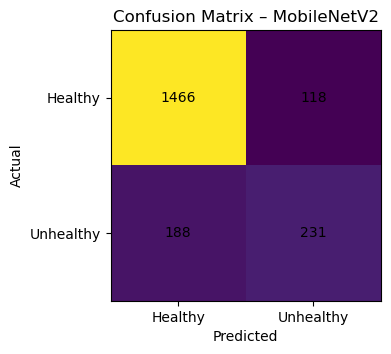

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.title("Confusion Matrix – MobileNetV2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["Healthy","Unhealthy"])
plt.yticks([0,1], ["Healthy","Unhealthy"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


In [38]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true, y_pred,
    target_names=["Healthy", "Unhealthy"]
))


              precision    recall  f1-score   support

     Healthy       0.89      0.93      0.91      1584
   Unhealthy       0.66      0.55      0.60       419

    accuracy                           0.85      2003
   macro avg       0.77      0.74      0.75      2003
weighted avg       0.84      0.85      0.84      2003



In [39]:
# Accuracy (~0.855) → overall correctness
# Recall(Unhealthy)→ how many risky cases you correctly detect 
# F1-score → balance between false alarms and missed cases
# Confusion Matrix → shows real-world reliability

In [40]:
# major project 

In [41]:
from tensorflow.keras.models import load_model

model = load_model("mobilenetv2_skin_cancer.h5")


In [42]:
IMG_SIZE = (128, 128)

def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = tf.expand_dims(img, axis=0)  # add batch dimension
    return img


In [43]:
image_path = r"C:\Users\sammi\minor_project\skin_data\New folder\ISIC_0024317.jpg"

img = preprocess_image(image_path)

prob = model.predict(img)[0][0]

label = "Unhealthy" if prob >= 0.5 else "Healthy"
confidence = prob if label == "Unhealthy" else 1 - prob

print(f"Prediction : {label}")
print(f"Confidence : {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction : Healthy
Confidence : 0.79


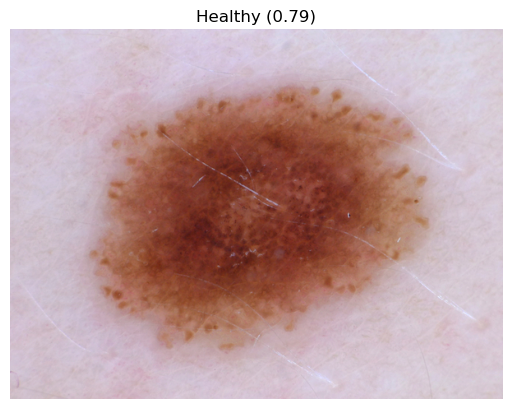

In [44]:
plt.imshow(Image.open(image_path))
plt.axis("off")
plt.title(f"{label} ({confidence:.2f})")
plt.show()


In [45]:
#web interface
model.save("mobilenetv2_skin_cancer.h5")
print("Model saved successfully")


Model saved successfully


In [46]:
import os
print(os.getcwd())


C:\Users\sammi


In [48]:
model.save(r"C:\Users\sammi\minor_project\skin_data\mobilenetv2_skin_cancer.h5")


In [50]:
pip install streamlit tensorflow pillow numpy


Note: you may need to restart the kernel to use updated packages.
